In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

from pathlib import PurePath

pd.options.mode.chained_assignment = None

save_figs = False

# Friedman 1 regression plotting
# run first recalibration_friedman1.ipynb
#task = 'friedman1_var'

# Residential Building regression plotting
# run first recalibration_uci.ipynb
task = 'ResBuild'

In [2]:
def get_df(i, ds, task):
    path = PurePath(
        'data', task, 'statistics_id={}_dataset={}.csv'.format(i, ds)
    )
    df = pd.read_csv(path)
    df['dataset'] = ds
    return df

df = pd.concat([
    get_df(i, ds, task)
    for i in range(1, 6)
    for ds in ['train', 'test', 'test_rc']
])

In [3]:
def df_plot(df, hue='dataset', size=None):
    g = sns.lineplot(data=df.reset_index(), x="iteration", y='estimate', hue=hue, linewidth=size)
    return g
    
def plot(df, iterations=None, statistics=None, datasets=None):
    
    mask = [True for _ in range(df.shape[0])]

    if iterations is not None:
        mask &= df['iteration'].isin(iterations)
    if statistics is not None:
        mask &= df['statistic'].isin(statistics)
    if datasets is not None:
        mask &= df['dataset'].isin(datasets)
    
    df_plot(df[mask])
    
def pretty_plot(df, iterations=None, statistics=None, datasets=None, ylim=(None, None), ylabel='DSS'):
    
    rc = {'figure.figsize': (4, 6)}
    font_scale = 2
    line_size = 3.5
    sns.set(rc=rc, font_scale=font_scale, context='paper')
    sns.set_style("white")
    
    mask = [True for _ in range(df.shape[0])]

    if iterations is not None:
        mask &= df['iteration'].isin(iterations)
    if statistics is not None:
        mask &= df['statistic'].isin(statistics)
    if datasets is not None:
        mask &= df['dataset'].isin(datasets)

    df_r = df[mask]
    
    df_r = df_r.rename(columns={'dataset': 'Model'})
    df_r.loc[df_r['Model']=='test', 'Model'] = 'Uncalibrated'
    df_r.loc[df_r['Model']=='test_rc', 'Model'] = 'Calibrated'
    plot = df_plot(df_r, 'Model', size=line_size)
    plot.set(ylim=ylim, ylabel=ylabel, xlabel='Training iteration')
    sns.despine()
    return plot
    
def delta_plot(df, statistic, iterations=None, ylim=(None, None), ylabel=None):

    rc = {'figure.figsize': (3, 3)}
    font_scale = 1.2
    sns.set(rc=rc, font_scale=font_scale, context='paper')
    sns.set_style("white")
    
    mask = [True for _ in range(df.shape[0])]

    if iterations is not None:
        mask &= df['iteration'].isin(iterations)
    if statistic is not None:
        mask &= df['statistic'] == statistic

    df_r = df[mask]
    df_r = df_r.rename(columns={'dataset': 'Model'})
    df_r.loc[df_r['Model']=='test', 'estimate'] -= df_r.loc[df_r['Model']=='test_rc', 'estimate']
    
    df_f = df_r.loc[df_r['Model']=='test']
    
    plot = df_plot(df_f, hue=None)
    plot.set(ylim=ylim, ylabel=ylabel)
    sns.despine()
    return plot

In [106]:
# cut out training irregularities
if task == 'friedman1_var':
    rng = range(0, 2000)
elif task == 'ResBuild':
    rng = range(300, 2000)

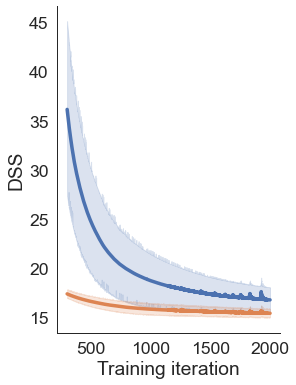

In [223]:
plot = pretty_plot(df, rng, ['PMCC'], ['test', 'test_rc'])
plot.legend([], [], frameon=False)
if save_figs:
    plot.figure.savefig('plots/fig_dss_{}.pdf'.format(task), bbox_inches = "tight")

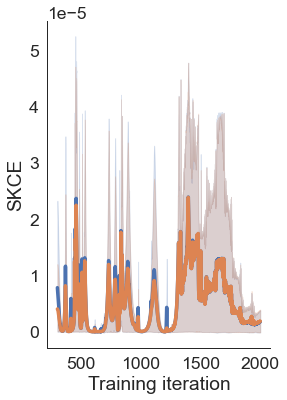

In [224]:
plot= pretty_plot(df, rng, ['SKCE (unbiased)'], ['test', 'test_rc'], ylabel='SKCE')
plot.legend([], [], frameon=False)
if save_figs:
    plot.figure.savefig('plots/fig_skce_{}.pdf'.format(task), bbox_inches = "tight")

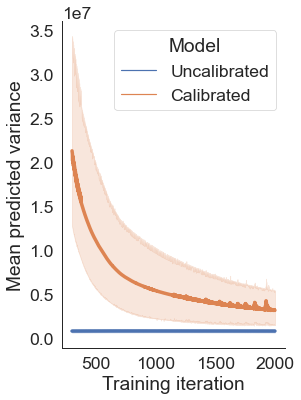

In [225]:
plot = pretty_plot(df, rng, ['Avg Var'], datasets=['test', 'test_rc'], ylabel='Mean predicted variance')
if save_figs:
    plot.figure.savefig('plots/fig_avg_var_{}.pdf'.format(task), bbox_inches = "tight")

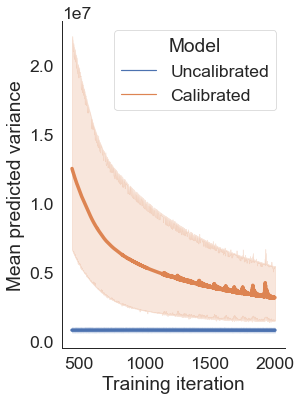

In [226]:
plot = pretty_plot(df, range(450, 2000), ['Avg Var'], datasets=['test', 'test_rc'], ylabel='Mean predicted variance')
if save_figs:
    plot.figure.savefig('plots/fig_avg_var_2_{}.pdf'.format(task), bbox_inches = "tight")

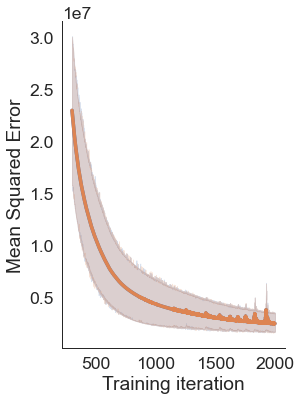

In [227]:
plot = pretty_plot(df, rng, ['MSE'], datasets=['test', 'test_rc'], ylabel='Mean Squared Error')
plot.legend([], [], frameon=False)
if save_figs:
    plot.figure.savefig('plots/fig_mse_{}.pdf'.format(task), bbox_inches = "tight")

In [ ]:
###############

In [5]:
#df_0 = df[df['iteration'].isin([500, 1000, 1500, 2000])]
# scaling the output
const = 1e-6
iters = np.arange(500, 2001, 250)
df_cal_mse = df[(df['dataset'] == 'test_rc') & (df['statistic'] == 'MSE') & df['iteration'].isin(iters)].groupby(['iteration']).mean() * const
df_cal_var = df[(df['dataset'] == 'test_rc') & (df['statistic'] == 'Avg Var') & df['iteration'].isin(iters)].groupby(['iteration']).mean() * const
df_uncal_var = df[(df['dataset'] == 'test') & (df['statistic'] == 'Avg Var') & df['iteration'].isin(iters)].groupby(['iteration']).mean() * const
df_cal_cor = df[(df['dataset'] == 'test_rc') & (df['statistic'] == 'Var SE Dist') & df['iteration'].isin(iters)].groupby(['iteration']).mean()
df_uncal_cor = df[(df['dataset'] == 'test') & (df['statistic'] == 'Var SE Dist') & df['iteration'].isin(iters)].groupby(['iteration']).mean()
df_cal_std = np.sqrt(df[(df['dataset'] == 'test_rc') & (df['statistic'] == 'Var SE Dist Var') & df['iteration'].isin(iters)].groupby(['iteration']).mean())
df_uncal_std = np.sqrt(df[(df['dataset'] == 'test') & (df['statistic'] == 'Var SE Dist Var') & df['iteration'].isin(iters)].groupby(['iteration']).mean())

In [7]:
#df_0 = pd.DataFrame({'MSE': df_cal_mse, 'Avg Var (Calibrated)': df_cal_var, 'Avg Var (Uncalibrated)': df_uncal_var})
df_0 = pd.concat([df_cal_mse, df_cal_var, df_uncal_var], axis=1).set_axis(['MSE', 'Avg Var (Calibrated)', 'Avg Var (Uncalibrated)'], axis=1).transpose().round(2)
print(df_0.to_markdown())
print(df_0.style.to_latex())
df_0

|                        |   500 |   750 |   1000 |   1250 |   1500 |   1750 |   2000 |
|:-----------------------|------:|------:|-------:|-------:|-------:|-------:|-------:|
| MSE                    | 10.48 |  5.87 |   4.3  |   3.51 |   3.12 |   2.74 |   2.57 |
| Avg Var (Calibrated)   | 11.04 |  6.89 |   5.4  |   4.55 |   4.11 |   3.63 |   3.32 |
| Avg Var (Uncalibrated) |  0.83 |  0.83 |   0.83 |   0.83 |   0.83 |   0.82 |   0.82 |
\begin{tabular}{lrrrrrrr}
iteration & 500 & 750 & 1000 & 1250 & 1500 & 1750 & 2000 \\
MSE & 10.480000 & 5.870000 & 4.300000 & 3.510000 & 3.120000 & 2.740000 & 2.570000 \\
Avg Var (Calibrated) & 11.040000 & 6.890000 & 5.400000 & 4.550000 & 4.110000 & 3.630000 & 3.320000 \\
Avg Var (Uncalibrated) & 0.830000 & 0.830000 & 0.830000 & 0.830000 & 0.830000 & 0.820000 & 0.820000 \\
\end{tabular}



iteration,500,750,1000,1250,1500,1750,2000
MSE,10.48,5.87,4.30,3.51,3.12,2.74,2.57
Avg Var (Calibrated),11.04,6.89,5.40,4.55,4.11,3.63,3.32
Avg Var (Uncalibrated),0.83,0.83,0.83,0.83,0.83,0.82,0.82


In [8]:
df_1 = pd.concat([
    df_cal_cor, df_uncal_cor, df_cal_std, df_uncal_std, 
], axis=1).set_axis(['SE Var Ratio (Calibrated)', 'SE Var Ratio (Uncalibrated)', '.', '.'], axis=1).transpose().round(2)
print(df_1.to_markdown())
print(df_1.style.to_latex())
df_1

|                             |   500 |   750 |   1000 |   1250 |   1500 |   1750 |   2000 |
|:----------------------------|------:|------:|-------:|-------:|-------:|-------:|-------:|
| SE Var Ratio (Calibrated)   |  0.82 |  0.79 |   0.79 |   0.79 |   0.79 |   0.79 |   0.79 |
| SE Var Ratio (Uncalibrated) | 11.33 |  6.96 |   5.36 |   4.53 |   4.07 |   3.71 |   3.51 |
| .                           |  2.17 |  2.31 |   2.43 |   2.57 |   2.56 |   2.58 |   2.59 |
| .                           | 30.72 | 19.32 |  15.09 |  13.24 |  12.13 |  11.5  |  11.22 |
\begin{tabular}{lrrrrrrr}
iteration & 500 & 750 & 1000 & 1250 & 1500 & 1750 & 2000 \\
SE Var Ratio (Calibrated) & 0.820000 & 0.790000 & 0.790000 & 0.790000 & 0.790000 & 0.790000 & 0.790000 \\
SE Var Ratio (Uncalibrated) & 11.330000 & 6.960000 & 5.360000 & 4.530000 & 4.070000 & 3.710000 & 3.510000 \\
. & 2.170000 & 2.310000 & 2.430000 & 2.570000 & 2.560000 & 2.580000 & 2.590000 \\
. & 30.720000 & 19.320000 & 15.090000 & 13.240000 & 12.1300

iteration,500,750,1000,1250,1500,1750,2000
SE Var Ratio (Calibrated),0.82,0.79,0.79,0.79,0.79,0.79,0.79
SE Var Ratio (Uncalibrated),11.33,6.96,5.36,4.53,4.07,3.71,3.51
.,2.17,2.31,2.43,2.57,2.56,2.58,2.59
.,30.72,19.32,15.09,13.24,12.13,11.50,11.22


In [110]:
#### dist shift

df_shift = pd.read_csv("data/dist_shift_uci_fgm.csv")
df_shift['epsilon'] = df_shift['epsilon'] // 2e6
grp_by = 'epsilon'
df_cal_mse = df_shift[(df_shift['model'] == 'cal') & (df_shift['statistic'] == 'MSE')].groupby([grp_by]).mean() * const
df_cal_var = df_shift[(df_shift['model'] == 'cal') & (df_shift['statistic'] == 'Avg Var')].groupby([grp_by]).mean() * const
df_uncal_var = df_shift[(df_shift['model'] == 'uncal') & (df_shift['statistic'] == 'Avg Var')].groupby([grp_by]).mean() * const
df_cal_cor = df_shift[(df_shift['model'] == 'cal') & (df_shift['statistic'] == 'Var SE Dist')].groupby([grp_by]).mean()
df_uncal_cor = df_shift[(df_shift['model'] == 'uncal') & (df_shift['statistic'] == 'Var SE Dist')].groupby([grp_by]).mean()

In [102]:
cols = ['MSE', 'Avg Var (Calibrated)', 'Avg Var (Uncalibrated)', 'SE Var Ratio (Calibrated)', 'SE Var Ratio (Uncalibrated)']
df_2 = pd.concat([df_cal_mse, df_cal_var, df_uncal_var, df_cal_cor, df_uncal_cor], axis=1).set_axis(cols, axis=1).transpose().round(2)
#print(df_2.to_latex())
#print("------------------")
print(df_2.to_markdown())
df_2

|                             |   0.0 |   1.0 |   2.0 |   3.0 |   4.0 |    5.0 |
|:----------------------------|------:|------:|------:|------:|------:|-------:|
| MSE                         |  2.57 |  6.02 | 16.36 | 33.65 | 57.83 |  88.78 |
| Avg Var (Calibrated)        |  3.32 |  3.36 |  3.39 |  3.43 |  3.46 |   3.5  |
| Avg Var (Uncalibrated)      |  0.82 |  0.83 |  0.84 |  0.86 |  0.87 |   0.88 |
| SE Var Ratio (Calibrated)   |  0.79 |  2.11 |  5.99 | 12.29 | 20.71 |  31.08 |
| SE Var Ratio (Uncalibrated) |  3.51 |  9.72 | 27.2  | 55.01 | 91.9  | 136.59 |


epsilon,0.0,1.0,2.0,3.0,4.0,5.0
MSE,2.57,6.02,16.36,33.65,57.83,88.78
Avg Var (Calibrated),3.32,3.36,3.39,3.43,3.46,3.50
Avg Var (Uncalibrated),0.82,0.83,0.84,0.86,0.87,0.88
SE Var Ratio (Calibrated),0.79,2.11,5.99,12.29,20.71,31.08
SE Var Ratio (Uncalibrated),3.51,9.72,27.20,55.01,91.90,136.59
